<h1 style="text-align: center"> Assignment #6 </h1>


<h4 style="text-align: center"> Kevin McManus </h4>
<h4 style="text-align: center"> Student ID: 109702479</h4>

## . MyData Class (revised)


In [1]:
#From Chapter 3
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import UnivariateSpline
import scipy.ndimage
from scipy import signal
from astropy.io import fits

class MyData:
    def __init__(self,filename='NoFile'):
        self.filename = filename
        self.ndim = 0 
        self.x = []
        self.nx = 0
        self.y = []
        self.ny = 0
        self.z = []
        self.nz = 0
        self.array = []
        self.header = []
        self.nxa = 0
        self.nya = 0
        
    def xline(self,xmin,xmax,nx):
        self.nx = nx
        self.ndim = 1
        self.x = np.linspace(xmin,xmax,nx)

    def yline(self,a,b):
        if(self.ndim == 1):
            self.ny = self.nx
            self.y = a + b*self.x
        else:
            print("x value not one dimensional")

    def plotxy(self):
        plt.cla()
        plt.title(self.filename)
        plt.plot(self.x,self.y)
        plt.show()

    def plotpoints(self):
        plt.cla()
        plt.title(self.filename)
        #plt.plot(self.x,self.y)
        plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()

    def GetFits(self, filename):
        self.filename = filename
        hdul = fits.open(filename)
        self.array = fits.getdata(filename)
        self.header = hdul[0].header
        sh = np.shape(self.array)
        self.nxa = sh[0]
        self.nya = sh[1]
        self.ndim = 2
            
    def GetTableData(self, filename):
        self.filename = filename
        data_array=np.genfromtxt(filename)
        s = data_array.shape
        if len(s) == 1 :
            self.x= data_array
            self.nx = s[0]
        if len(s) == 2 :
            self.x = data_array[:, 0]
            self.y = data_array[:, 1]
            self.nx = s[0]
            self.ny = s[0] #one y value for each x value

    def WriteTableData(self,filename='test.txt'):
        f = open(filename,"w")
        if self.ny == 0:
            for i in range(0,self.nx):
                f.write('%8.4f\n' % self.x[i] )
        else:
            for i in range(0,self.nx):
                f.write('%8.4f  %8.4f\n' % (self.x[i],self.y[i]))
        f.close()

    def Quicklook(self):
        if (self.nx == 0):
            print("Whoops! No Data")
            return
        plt.cla()
        if self.ny == 0:
            plt.plot(self.x, c='black')
        else:
            plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()
        print("length of x list is ",len(self.x), "items")
        
    def ReadInteger16(self,filename,nxa=256,nya=256):
        self.filename = filename
        data = np.fromfile('m33.dat', dtype='i2')
        self.array = np.reshape(np.array(data),(nxa,nya))
        self.ndim = 2
        self.nxa = nxa
        self.nya = nya
        
    def WriteFloat64(self,filename="test.dat"):
        self.filename = filename
        f= open(self.filename,"w+")
        self.x.tofile(f)
        f.close()

    def ReadFloat64(self,filename="test.dat",nxa=256,nya=256, ftype='binary'):
        self.filename = filename
        if ftype == 'binary':
            data = np.fromfile(filename, dtype='f8')
        elif ftype == 'text':
            data = np.loadtxt(filename)
        else:
            raise ValueError('ftype must be text or binary.')

        self.array = np.reshape(np.array(data),(nxa,nya))
        self.ndim = 2
        self.nxa = nxa
        self.nya = nya

    def ReadExcelColumn(self, filename, sheetname, columnname):
        self.filename = filename
        e = pd.ExcelFile(filename)
        ep = e.parse(sheetname)
        df=ep[columnname]
        self.x = df.values
        self.nx = len(self.x)
        self.ndim = 1
        
    def WriteExcelColumn(self, filename):
        df = pd.DataFrame(data=self.x)
        with pd.ExcelWriter(filename) as writer:
            df.to_excel(writer)
            
    def MyHistogram(self,bins=10):
        hi=np.histogram(self.x,bins=bins)
        hy=np.array(hi[0])
        hx=np.array(hi[1])
        hx=hx[1:]
        plt.cla()
        #plt.plot(hx,hy,linestyle='steps')
        plt.plot(hx,hy,linestyle='-')
        plt.show()

    def Slice(self, slc):
        """
        slices self.x and self.y according to slc
        """
        if self.nx == 0:
            raise ValueError('Data object has no data to slice')
        self.x = self.x[slc]
        self.nx = len(self.x)
        if self.ny != 0:
            self.y = self.y[slc]
            self.ny = len(self.y)

    def MyHistogram(self,**kwargs):
        ax = kwargs.pop('ax', None)
        xlim = kwargs.pop('xlim', (None, None))
        title = kwargs.pop('title', self.filename)
        density = kwargs.pop('density', False)
        grid = kwargs.pop('grid', True)
        which = kwargs.pop('which','x')

        data = getattr(self, which)
        if which=='array':
            data = data.flatten()


        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        ax.hist(data, density=density, **kwargs)
        
        ylab = ('Density' if density else 'Count') + f' of {which}'
        ax.set_ylabel(ylab)
        ax.set_title(title)
        ax.set_xlim(xlim)
        if grid:
            ax.grid(axis='y')

## 1. Swim Meet
>You are a timer at a swim meet. There are eight lanes and eight timers, each with a stopwatch.


### Calibration
>Suggest a way to calibrate each stopwatch so there is effectively no difference in the time rate
each is showing. Answer this in a markdown line of surname_6.ipynb


Presumably, swimmers and their coaches will want to compare thier times to those of other swim meets, shall we say, at the NCAA level. Thus the precision necessary for the timers of this meet must meet NCAA standards. So the first calibration step would be to obtain the NCAA standards.

As for the accuracy of the timings, there are two sources of error: systematic and random.  Systematic errors are imbedded in the timing instrument itself (i.e. the stopwatch). Such an instrument may measure nine seconds when ten seconds have elapsed. Such errors would be proportional to the interval of time measured, e.g., the stopwatch reads 18 seconds when in reality 20 seconds have elapsed. Different intruments may (probably do) have different characteristics.

The timer, that is the operator of the timing instrument, introduces the random error element. For example, the time they take to start the instrument upon hearing the start signal or stop the instrument upon seeing a swimmer complete the event will be a random variable that varies from one trial to the next. The distribution of that random variable will most likely differ among timers.

#### Calibration Proposal

1. Assign a stopwath to each timer. This is the instrument they are to use in calibration and in the actual swimmeet.
1. Have each timer/stopwatch pair watch previously recorded videos of swimming events. The events should vary in length (e.g. 100m 200m, 400IM). The more events and the greater the diversity of the events, the better.
1. The timer should start and stop their watch at the start and end of each event they watch and record the time indicated on their watch and the official time for the event.
1. The head timer (me) collect the data from each timer.
1. For each dataset fit a linear regression line with y being the official time and x  being the time measured by the observer.

The result of this last step will be a fitted line of the form `y = a +bx` where `x` is the observed time and `y` is the official time. In other words, this equation predicts the official (calibrated) time from the observed time.  The coefficient `b` in the equation represents the systemic error of the instrument and the constant `a` represents mean error introduced by the timer.

This method produces one such equation for each timer/stopwatch pair. As the swimmeet proceeds, the head timer adjusts each time observed according to the observer's (timer's) specific equation.



### Histogram and Winning Time
>There are ten heats of eight each. The resultant times are in SwimMeetTimes.txt. Read the times
into an instance of MyData. Create a Histogram of the times. Fiddle with the number of bins
until you feel the histogram gives the best information to the eye.
Print the winning time and the losing time.
Print the mean and standard deviations of the times.

It is unclear from the format of the file whether the data vector contained in it is $heats\ \times \ lanes$ or $lanes\ \times \ heats$. For purposes here, we'll assume $heats\ \times\ lanes$. Thus the `x` dimension is heats (nx=10) and the `y` dimension is lanes (ny=8)

In [2]:
swim1 = MyData()
swim1.ReadFloat64(filename='SwimMeetTimes.txt', nxa=10, nya=8,ftype='text')

#make a data frame for easy to read display
lanes = [f'Lane_{i}' for i in range(1,9)]
df = pd.DataFrame(swim1.array, columns=lanes, index=pd.Index(range(1,11), name='Heat'))
df

,Lane_1,Lane_2,Lane_3,Lane_4,Lane_5,Lane_6,Lane_7,Lane_8
Heat,,,,,,,,
1,28.961,29.772,29.522,30.224,30.410,34.492,30.336,30.004
2,29.367,31.743,28.851,30.355,32.921,31.030,31.044,25.220
3,32.935,32.859,31.043,29.233,33.199,25.455,29.713,32.217
4,31.664,31.251,30.806,29.275,32.693,29.801,33.476,27.190
5,30.122,27.649,27.570,31.185,30.686,31.245,28.613,32.204
6,31.258,35.031,27.224,30.355,32.582,31.072,26.505,28.322
7,27.217,25.559,31.823,32.821,31.057,29.077,24.196,30.123
8,31.077,31.987,26.837,28.656,28.101,31.247,24.132,29.090
9,33.285,32.771,32.939,29.236,33.801,30.612,28.909,31.616


Text(0.5, 0, 'Event Time (Seconds)')

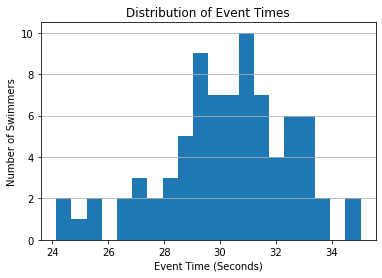

In [3]:
#histogram of all of the times
swim1.MyHistogram(which='array',bins=20,title='Distribution of Event Times')
plt.ylabel('Number of Swimmers'); plt.xlabel('Event Time (Seconds)')
    

In [4]:
#winning time=minimum, losing time = maximum
winning_time_i = swim1.array.argmin()
winning_time_ij = np.unravel_index(winning_time_i, swim1.array.shape)
print(f'Winning time: {swim1.array[winning_time_ij]} seconds, Heat: {winning_time_ij[0]+1}, Lane: {winning_time_ij[1]+1}')

losing_time_i = swim1.array.argmax()
losing_time_ij = np.unravel_index(losing_time_i, swim1.array.shape)
print(f'Losing (slowest) time: {swim1.array[losing_time_ij]} seconds, Heat: {losing_time_ij[0]+1}, Lane: {losing_time_ij[1]+1}')

Winning time: 24.132 seconds, Heat: 8, Lane: 7
Losing (slowest) time: 35.031 seconds, Heat: 6, Lane: 2


In [5]:
#mean and standard deviation
print(f'Mean event time: {swim1.array.mean():.2f} seconds')
print(f'Standard deviationi of event times: {swim1.array.std(ddof=1):.2f} seconds')

Mean event time: 30.23 seconds
Standard deviationi of event times: 2.30 seconds


### Handle Disqualifications

>Another ten heats are run and the times recorded in SwimMeetTimes2.txt. This time, some of the
swimmers were disqualified and their times were recorded as 0. Repeat the exercise, but this
time write a few extra lines of code of to strip the zeroes before continuing.

Perhaps the easiest way to deal with invalid data is to use the capabilities in the `numpy.ma` module, where `ma` stands for "masked array".  See the [documentation](https://numpy.org/doc/stable/reference/maskedarray.generic.html). A brief demonstration follows:

In [6]:
#masked array demo
import numpy.ma as ma

#create an array that has missing data
xx = np.array([1.0, 2.0, np.nan, 3.0])
print(f'Array with missing data: {xx}')
print(f'Standard Deviation of array: {xx.std(ddof=1)}')

#make masked array and mask out the missing values
yy = ma.masked_array(xx, mask=np.isnan(xx))
print(f'Masked array: {yy}')
print(f'Standard deviation of masked array: {yy.std(ddof=1)}')

Array with missing data: [ 1.  2. nan  3.]
Standard Deviation of array: nan
Masked array: [1.0 2.0 -- 3.0]
Standard deviation of masked array: 1.0


Notice that the `np.std` (standard deviation) function returns a NotANumber when it encounters one in the input data. `np.std` skips masked values when passed a masked array and returns the standard deviation of the non-masked values.

To apply this capability to the task at hand, we'll read in the second data file, then mask out the disqualified entrants whose times are recorded as 0, then print out the means and standard deviations of the unmasked and masked times.

Total number of times: 80, number of disqualifications: 2
*** Before DQ exclusion:
	Mean event time: 29.23 seconds
	Standard deviation of event times: 5.29 seconds
	Winning time: 0.0 seconds, Heat: 4, Lane: 1
	Losing (slowest) time: 31.987 seconds, Heat: 8, Lane: 2

*** After DQ exclusion:
	Mean event time: 29.98 seconds
	Standard deviation of event times: 2.44 seconds
	Winning time: 25.319 seconds, Heat: 2, Lane: 5
	Losing (slowest) time: 31.987 seconds, Heat: 8, Lane: 2


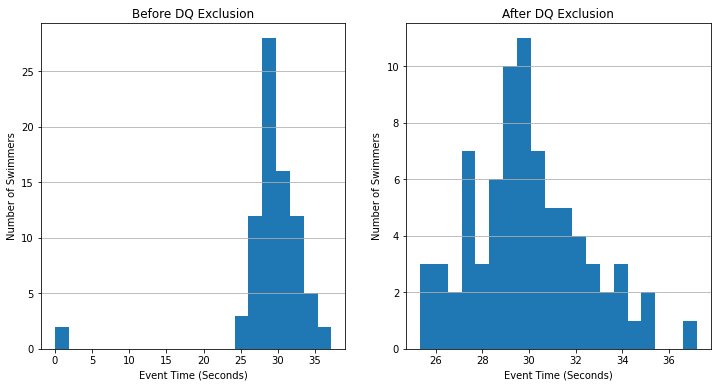

In [19]:
#set up for plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

swim2 = MyData()
swim2.ReadFloat64(filename='SwimMeetTimes2.txt', nxa=10, nya=8,ftype='text')
print(f'Total number of times: {swim2.array.size}, number of disqualifications: {(swim2.array == 0.0).sum()}')

print('*** Before DQ exclusion:')
#mean and standard deviation
print(f'\tMean event time: {swim2.array.mean():.2f} seconds')
print(f'\tStandard deviation of event times: {swim2.array.std(ddof=1):.2f} seconds')

#winning time, heat and lane
winning_time_i = swim2.array.argmin()
winning_time_ij = np.unravel_index(winning_time_i, swim2.array.shape)
print(f'\tWinning time: {swim2.array[winning_time_ij]} seconds, Heat: {winning_time_ij[0]+1}, Lane: {winning_time_ij[1]+1}')

#losing time, heat and lane
losing_time_i = swim2.array.argmax()
losing_time_ij = np.unravel_index(losing_time_i, swim2.array.shape)
print(f'\tLosing (slowest) time: {swim1.array[losing_time_ij]} seconds, Heat: {losing_time_ij[0]+1}, Lane: {losing_time_ij[1]+1}')

#histogram of all of the times
swim2.MyHistogram(ax=axs[0],which='array',bins=20,title='Before DQ Exclusion')
axs[0].set_ylabel('Number of Swimmers'); axs[0].set_xlabel('Event Time (Seconds)')


#exclude the dq's
data = ma.masked_array(swim2.array, swim2.array==0)
swim2.array=data

print('\n*** After DQ exclusion:')
#mean and standard deviation
print(f'\tMean event time: {swim2.array.mean():.2f} seconds')
print(f'\tStandard deviation of event times: {swim2.array.std(ddof=1):.2f} seconds')

#winning time, heat and lane
winning_time_i = swim2.array.argmin()
winning_time_ij = np.unravel_index(winning_time_i, swim2.array.shape)
print(f'\tWinning time: {swim2.array[winning_time_ij]} seconds, Heat: {winning_time_ij[0]+1}, Lane: {winning_time_ij[1]+1}')

#losing time, heat and lane
losing_time_i = swim2.array.argmax()
losing_time_ij = np.unravel_index(losing_time_i, swim2.array.shape)
print(f'\tLosing (slowest) time: {swim1.array[losing_time_ij]} seconds, Heat: {losing_time_ij[0]+1}, Lane: {losing_time_ij[1]+1}')

#histogram of all of the times
swim2.MyHistogram(ax=axs[1],which='array',bins=20,title='After DQ Exclusion')
axs[1].set_ylabel('Number of Swimmers'); zz=axs[1].set_xlabel('Event Time (Seconds)')



## 2. Propagation of Errors
>You want to measure the radius of a star under the assumption it is a perfect blackbody.
You measure:
>>The Luminosity to 1%.

>>The Distance to 2%

>>The Temperature to 1%

>To what percent have you measured the radius? 

The relationship among luminosity ($L$), temperature ($T$) and radius ($R$) is:
$$
L = \sigma_{sb}T^4\times 4\pi R^2
$$
where $\sigma_{sb}$ is the Stefan-Boltzmann constant.
If we have measured quantites for $T$ and $L$, we can infer $R$ as follows:
$$
R = \left( \frac{L}{4\pi\sigma_{sb}T^4}\right)^\frac{1}{2}
$$
Uncertainty in the measurements of $L$ and $T$ propagate through to uncertainty in $R$.


Some error propagation formulas from Lecture #10, in which $\delta \ll 1$:

**Squared Term:** $(1+\delta)^2 \approx 1 + 2\delta$

**Product of Two Terms:** $(1+\delta)(1+\epsilon) \approx 1 + \delta + \epsilon$

**Reciprocal:** $\frac{1}{1+\delta} \approx 1-\delta$

**Square Root:** $\sqrt{1+\delta} \approx 1+\frac{\delta}{2}$

In the problem at hand, both $L$ and $T$ are measured to a precision of 1%, that is $L(1\pm 0.01)$ and $T(1\pm 0.01)$.

Let $X$ be the denominator of the equation for $R$:
$$
\begin{align*}
X &= 4\pi\sigma_{sb}(T(1\pm 0.01))^4 \\
&= 4\pi\sigma_{sb}T^4(1 \pm 0.01)^2(1 \pm 0.01)^2 \\
&= 4\pi\sigma_{sb}T^4(1 \pm 2\times 0.01)(1 \pm 2\times 0.01) \quad \text{Squared Term Rule}\\
&= 4\pi\sigma_{sb}T^4(1 \pm  0.04)\\
&= X(1 \pm  0.04)
\end{align*}
$$

By the **Reciprocal Rule**, $\frac{1}{X\pm \delta} \approx X \pm \delta$ so in this case, $\frac{1}{X} \approx X(1\pm 0.04)$. Multiplying the reciprocal of $X$ by the luminoisty $L$, the error terms add, so thier product is:
$$
\begin{align*}
L\times\frac{1}{X} &= L(1.01) \times (\frac{1}{X})(1+0.04) \\
&= \frac{L}{X}(1\pm 0.01 \pm 0.04)\\
&= \frac{L}{X}(1 \pm 0.05)
\end{align*}
$$

And finally, using the square root rule on this ratio:
$$
\begin{align*}
R &= \sqrt{\frac{L}{X}(1 \pm .05)} \quad \approx \left(\frac{L}{X}\right)^{\frac{1}{2}}(1 \pm .025)\\
R &\approx \left(\frac{L}{4\pi\sigma_{sb} T^4}\right)^{\frac{1}{2}} (1 \pm 0.025)
\end{align*}
$$

So, under the assumption that luminosity and temperature are measured to a precision within 1%, the radius is calculated to a precision of 2.5%.

### 2.1 Experimental Results
In this section, we'll simulate temperature and luminosity measurements of the Sun, from which we'll calculate its radius. We'll calculate the mean and standard deviation of the simulated results and compare them to the values predicted above.

In [8]:
NTRIALS = 10000
sigma_sb = 5.6703744191844314e-08 #stefan-boltzmann WK^-4

np.random.seed(1234) # make results reproducible

T_sun = 5780 ; T_sun_error = 0.01*T_sun # K
L_sun = 3.828e+26; L_sun_error = 0.01*L_sun #Watt
R_sun = 695700000.0 #km, true solar radius

#simulate temperature and luminosity measurements
temps = np.random.normal(loc=T_sun, scale=T_sun_error, size=NTRIALS)
lums = np.random.normal(loc=L_sun, scale=L_sun_error, size=NTRIALS)

#calculate radius from simulated measurements
rads = np.sqrt(lums/(4*np.pi*sigma_sb*temps**4))
# calculate mean and std dev of the sim'd calculations
R_bar = rads.mean()
R_error = rads.std(ddof=1)

#predict radius and error
R_pred = np.sqrt(L_sun/(4*np.pi*sigma_sb*T_sun**4))
R_pred_error = R_pred*0.025 #from equations above

#shove it into a MyData object for ease of plotting
experiment = MyData(filename='Solar Radius Experiment')
experiment.x = rads


In [9]:
#compare calculated and predicted results
print('**Radius')
print(f'\tTrue radius: {R_sun:.3e} km, Predicted Radius: {R_pred:.3e} km, Calculated Radius: {R_bar:.3e} km')
print(f'\tRatio to True Radius: Predicted: {R_pred/R_sun:.3f}  Calculated:  {R_bar/R_sun:.3f}')
print('\n**Error')

pred_err_frac = R_pred_error/R_pred; calc_err_frac = R_error/R_bar
print(f'\tPredicted Radius Error: {R_pred_error:.3e} km, Calculated Radius Error: {R_error:.3e} km, ratio: {R_pred_error/R_error:.3f}')
print(f'\tPredicted Sun Radius {R_pred:.3e}(1 +/- {pred_err_frac:.3f}), Calculated Sun Radius {R_bar:.3e}(1 +/- {calc_err_frac:.3f})')

**Radius
	True radius: 6.957e+08 km, Predicted Radius: 6.938e+08 km, Calculated Radius: 6.937e+08 km
	Ratio to True Radius: Predicted: 0.997  Calculated:  0.997

**Error
	Predicted Radius Error: 1.734e+07 km, Calculated Radius Error: 1.427e+07 km, ratio: 1.216
	Predicted Sun Radius 6.938e+08(1 +/- 0.025), Calculated Sun Radius 6.937e+08(1 +/- 0.021)


The calculated and predicted radii are within 0.3% of the true solar radius and virtually identitcal to eachother. The predicted error, however is about 22% higher than the calculated error, which seems like quite a lot. This is likely due to the use of successive approximations -- four in this problem -- and the approximation errors accumulate.  Perhaps this is a good thing: precision infered by a series of successive approximation will tend to underestimate the precision or overstate the error in the  result.

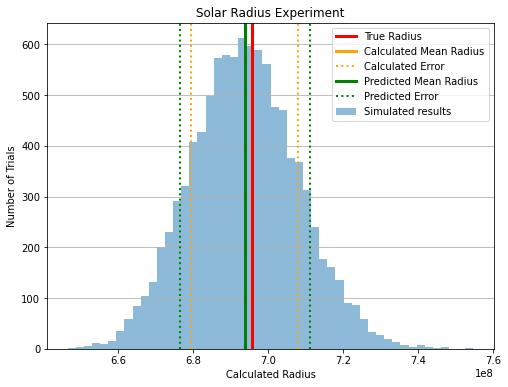

In [10]:
#show results graphically
fig, ax = plt.subplots(figsize=(8,6))
experiment.MyHistogram(ax=ax, bins=50, label='Simulated results', alpha=0.5)
ax.axvline(R_sun, color='red', lw=3, ls='-', label='True Radius')

#calculated mean and standard deviation
ax.axvline(R_bar, color='orange', ls='-', lw=3, label='Calculated Mean Radius')
ax.axvline(R_bar+R_error, color='orange', ls=':', lw=2  )
ax.axvline(R_bar-R_error, color='orange', ls=':', lw=2, label='Calculated Error')

#predicted mean and standard deviation
ax.axvline(R_pred, color='green', ls='-', lw=3, label='Predicted Mean Radius')
ax.axvline(R_pred+R_pred_error, color='green', ls=':', lw=2  )
ax.axvline(R_pred-R_pred_error, color='green', ls=':', lw=2, label='Predicted Error')

ax.set_xlabel('Calculated Radius')
ax.set_ylabel('Number of Trials')
ax.legend(loc='upper right')



The figure above shows the mean and standard deviation (error) calculated across the simulated measurements (green lines) and the mean and standard deviation predicted from the precision of the temperature and luminoisity measurements (orange lines).  The calculated and predicted mean radius are almost identical so the plotted green line (predicted) obscures the plotted orange line (calculated).
Note that both the calculated and predicted error limits contain the true solar radius at approximately their midpoints.
The higher precision of the calculated results vis-a-vis the predicted results is readily apparent.

### 3. Probability that the President Asked for Help from Russia Given that he Asked for Help from Ukraine

>Let us use Bayes Theorem on a hypothetical example of a President of the United States who
has been accused of using foreign governments to help win elections in this country.
First estimate the Prior Probability. Call it x. It is the probability that any president or
presidential candidate would ask another country for help from a foreign power in a US election.
Then a new event occurs: The president is found to have asked Ukraine for help in his next
election.
Estimate the probability of his asking another country (like Ukraine) for help if he already
asked Russia (or some other country) for help. Call it y.
Estimate the probability of asking a country like Ukraine for help if he has never before asked
for help. Call it z.
What is the revised (posterior) probability estimate of his having cheating with Russia too?
Use the formula P=xy/(xy+z(1-x)) 

Let:
$$
\begin{equation*} U =
  \begin{cases}
    0       & \quad \text{if President did not ask for Ukranian help}\\
    1  & \quad \text{if President asked for Ukranian help}
  \end{cases}
\end{equation*}
$$
and:
$$
\begin{equation*} R =
  \begin{cases}
    0       & \quad \text{if President did not previously ask for Russian help}\\
    1  & \quad \text{if President previously asked for Russian help}
  \end{cases}
\end{equation*}
$$

and let A be our prior knowledge of the probability that any preseident has asked for election help from any country in the past. Suppose:

$$
  \begin{align*}
    P(A=0)  &= 0.95 \quad \text{probability that any president does not ask for help}\\
    P(A=1)  &= 0.05 \quad \text{probability that any president asks for help}
  \end{align*}
$$

Suppose further that if a president asked for election help previously, the odds are three to one that the president will ask for it again. This leads to the following four cases:
$$
\begin{align*}
P(U=0|R=0) &= P(A=0) = 0.95 \\
P(U=1|R=0) &= P(A=1) = 0.05 \\
P(U=0|R=1) &= 0.25 \\
P(U=1|R=1) &= 0.75
\end{align*}
$$

Given that we know $U=1$, that is the President asked Ukraine for election help, we wish to determine the probability that the President previously asked Russia.  That is, we wish to compute $P(R=1|U=1)$


### Bayes' Rule

Bayes Rule, adapted for this problem states:
$$
P(R=r|U=1) = \frac{P(R=r)\times P(U=1|R=r)}{\sum_{r=0,1}P(R=r)\times P(U=1|R=r)} \quad \text{for}\  r = 0,1
$$

$P(R=0)$ and $P(R=1)$ are the same as $P(A=0)$ and $P(A=1)$, respectively, that is the prior probabilty that a president asks Russia or any other country for election help which is assumed to be $0.05$.
Given the four-case conditional probabilities above, Bayes' Rule works out for $r=1$ to:
$$
\begin{align*}
P(R=1|U=1) &= \frac{P(R=1)\times P(U=1|R=1)}{\sum_{r=0,1}P(R=r)\times P(U=1|R=r)}\\
&=\frac{0.05\times 0.75}{(0.95\times 0.05 + 0.05\times 0.75)}\\
&= 0.44

\end{align*}
$$
Thus under the assumed probabilities, the probability that the President asked for Russian help increased from 0.05 to 0.44 when it became known that the President asked for Ukranian help.
**This represents a change of 0.39 from the prior belief.**


### Using the `x`, `y` and `z` Substitutions

Let `x` be the prior probability that a president asks any country for election help. This is by definition $P(A=1)$ in our previous notation and assumed to be 0.05.

Let `y` be the probabilty that a president asks a second country for election help given that the president previously asked a first. This is by definition $P(U=1|R=1)$ from previous notation and assumed to be 3 times more likely (than not asking) or 0.75.

Let `z` be the probability that a president asks Ukraine for help given that the president has previously never asked Russia or anybody else for help. In our previous notation, this is $P(U=1|R=0)$ which is the same as $P(A=0)$, i.e., the probability that the president asks for help the first time.

Then the formula:
$$
P(R=1|U=1) = \frac{x\times y}{(x\times y+z\times(1-x))}
$$
works out to:
$$

P(R=1|U=1) = \frac{0.05\times 0.75}{0.05\times 0.75 + 0.05(1-0.05) }
= \frac{0.04}{0.04 + 0.05}
= 0.44
$$
which is the same result as when we used Bayes' Rule directly.


### Sensitivity Analysis

The calculations above assumed specific values for the prior probability: the probability that a president would ask any country for election help and for the conditional probability: the probability that a president would ask for election help a second time. We showed how much more probable the second request became.

In this section, we examine the impact on the change in probability of varying the input assumptions. We vary both the prior and the conditional probabilities over the range (0..1.0) and compute the <u>difference</u> from the prior.

In [11]:
def bayes(prior, cond):
    newprob = (prior*cond)/(prior*(1-prior)+prior*cond)
    return newprob

def makebins(min=0.0, max=1.0, nsteps=10):
    #calcualte bin boundaries
    bin_bound, bstep = np.linspace(min, max, nsteps+1, retstep=True, endpoint=True)
    #calculate bin mid points
    bin_mid = (bin_bound+bstep/2)[:-1]
    return bin_bound, bin_mid

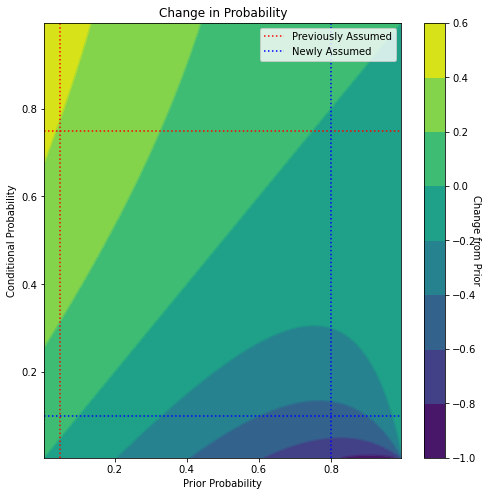

In [12]:
Nsteps = 100
prior_bounds, priors = makebins(nsteps = Nsteps)
cond_bounds, conds = makebins(nsteps = Nsteps)
Priors, Conds = np.meshgrid(priors, conds)
new_prob = bayes(Priors, Conds)

fig, ax = plt.subplots(figsize=(8,8))
#pcm = ax.pcolormesh(prior_bounds, cond_bounds, new_prob-Priors)
pcm=plt.contourf(Priors, Conds, new_prob-Priors)
ax.contour(Priors, Conds, new_prob-Priors )

#previous assumptions
ax.axhline(0.75, color='red', ls=':')
ax.axvline(0.05, color='red', ls=':', label='Previously Assumed')

#new assumptions
ax.axhline(0.1, color='blue', ls=':')
ax.axvline(0.8, color='blue', ls=':', label='Newly Assumed')

cbar = plt.colorbar(pcm)
cbar.set_label('Change from Prior', rotation=270)
ax.set_title('Change in Probability')
ax.set_ylabel('Conditional Probability')
ax.set_xlabel('Prior Probability')
ax.legend(loc='upper right')

The figure above shows the <u>change</u> from the prior probility for each pair of  prior and conditional probabilities in the grid. The dotted red lines show the prior and conditional probbabilities assumed in the previous two sections (0.05 and 0.75, respectively). The dotted blue line represent a new set of assumptions which we will explore below.

Notice that the largest changes in probability occur in the upper left quadrant of the graph. This region corresponds loosely to "presidents are unlikely to ask for help, but if they do, they are highly likely to ask for it a second time." On the other hand, decreases in probability are in the region where "presidents are highly likely to ask for help, but only once." That the President asked the Ukraine for help does not provide any indication that he also asked Russia.

This last conclusion may seem somewhat counter-intuitive. To take a numerical example, suppose any president is 80% likely to ask for help, and if the president did, only 10% likely to ask a second time.

According to __Bayes' Rule__:
$$
P(R=r|U=1) = \frac{P(R=r)\times P(U=1|R=r)}{\sum_{r=0,1}P(R=r)\times P(U=1|R=r)} \quad \text{for}\  r = 0,1
$$
which under the new assumptions becomes:
$$
\begin{align*}
P(R=1|U=1) &= \frac{P(R=1)\times P(U=1|R=1)}{\sum_{r=0,1}P(R=r)\times P(U=1|R=r)}\\
&=\frac{0.8\times 0.1}{(0.20\times 0.80 + 0.80\times 0.1)}\\
&= 0.33

\end{align*}
$$

which is a decrease of 0.47 from the prior assumption. See blue crosshairs in the plot above. In this case it is assumed to be unlikely that the President asks for help second time, and given that he made a request, the likelihood of the it being a second request decreases.